In [ ]:
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu, compute_az_el_dist
import numpy as np
import json, gc, pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import importlib, minmax_solvers
importlib.reload(minmax_solvers)
from minmax_solvers import (
    solve_game_mirror_prox,
    solve_game_bestresp_Q0_then_Q1,
    solve_game_proxBR,
    solve_game_extragradient,
    solve_game_pdhg,
    solve_game_proxBR_pp
)
# Your utils
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu
from sionna.rt import PlanarArray


import numpy as np
from numpy.linalg import cholesky, solve, eigh


c = 3e8  # speed of light (m/s)
fc = 10e9  # Carrier frequency: 10 GHz
wavelength = c / fc
bandwidth = 100e6  # 100 MHz
tx_power_dbm = 30  #  dBm
jam_power_dbm = 50
k = 1.38e-23  # Boltzmann 
GT = 13 # db gain-to-noise-temperature for for 0.33m Equivalent satellite antenna aperturesatellites, or can be 5 dB K^(-1) for 0.13m Equivalent satellite antenna aperture
La = 5 # dB
GT_linear_inv = 10 ** (-GT / 10)
La_linear = 10 ** (La / 10)
noise_power_watt = k * bandwidth * GT_linear_inv * La_linear
Tx_power_watt = 10 ** ((tx_power_dbm  - 30)/ 10)  
Jam_power_watt = 10 ** ((jam_power_dbm  - 30)/ 10)

In [ ]:
from sionna.rt import Scene, Receiver, Transmitter, PlanarArray, PathSolver
import numpy as np
import vsat_dish_3gpp


def compute_cir(tx_pos, rx_pos, tx_array, rx_array,tx_look_at, rx_look_at, frequency=10e9):
    """
    Compute CIR from a single transmitter to multiple receivers using synthetic arrays.
    
    Args:
        tx_pos:        (3,) list or np.array for transmitter position
        rx_pos_array:  (m,3) array of receiver positions
        tx_array:      PlanarArray for the transmitter
        rx_array:      PlanarArray for all receivers (shared)
        frequency:     Frequency in Hz

    Returns:
        a_list:    list of CIR amplitude arrays, one per RX
        tau_list:  list of delay arrays, one per RX
    """
    scene = Scene()
    scene.frequency = frequency
    scene.synthetic_array = True

    # Add transmitter
    scene.tx_array = tx_array
    tx = Transmitter(name="tx", position=tx_pos, display_radius=200)
    scene.add(tx)
    
    if isinstance(tx_look_at, str) and tx_look_at.lower() in ["up-z", "up", "z"]:
        tx_look_at = np.array(tx_pos) + np.array([0.0, 0.0, 1.0])
    tx.look_at(tx_look_at)
    # Add receivers
    scene.rx_array = rx_array
    rx_list = []
    for i, rx_pos in enumerate(rx_pos):
        rx = Receiver(name=f"rx{i}", position=rx_pos)
        scene.add(rx)
        rx.look_at(rx_look_at)
        rx_list.append(rx)


    # Solve paths
    solver = PathSolver()
    paths = solver(scene=scene,
                   max_depth=0,
                   los=True,
                   synthetic_array=True,
                   seed=41)

    # Get CIRs
    a_all, tau_all = paths.cir(normalize_delays=False, out_type="numpy")

    for tx_name in scene.transmitters:
        scene.remove(tx_name)
    for rx_name in scene.receivers:
        scene.remove(rx_name) 
    
    return a_all, tau_all

jam_rows =8
jam_cols = 8
jam_antennas = jam_cols*jam_rows

sat_rows = 1
sat_cols = 1
sat_antennas = sat_cols*sat_rows

tx_rows = 8
tx_cols = 8
tx_antennas = tx_cols*tx_rows

tx_array = PlanarArray(num_rows=tx_rows, num_cols=tx_cols,
                        vertical_spacing=0.5, horizontal_spacing=0.5,
                        pattern="tr38901", polarization="V")
                        # pattern="iso", polarization="V")

jam_array = PlanarArray(num_rows=jam_rows, num_cols=jam_cols,  
                            vertical_spacing=0.5, horizontal_spacing=0.5,
                        #  pattern="vsat_dish",
                            pattern="tr38901",
                            polarization="V")

sat_array = PlanarArray(num_rows=sat_rows, num_cols=sat_cols,
                             vertical_spacing=0.5, horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")

def collapse_channel(a_cir, t_idx=0):
    """
    Collapse channel tensor at a given time index.
    Input:
      a_cir: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
    Output:
      H_t: (M, N), M = num_rx*num_rx_ant, N = num_tx*num_tx_ant
    """
    nr, nra, nt, nta, npaths, ntimes = a_cir.shape
    assert 0 <= t_idx < ntimes
    H_t = a_cir[..., t_idx]             # select time slice
    H_t = H_t.sum(axis=-1)              # sum over paths
    H_t = H_t.reshape(nr*nra, nt*nta)   # merge Rx/Tx antennas
    return H_t


In [ ]:

   
    

def make_tqdm_progress(total, desc, position=1, leave=False):
    bar = tqdm(total=total, desc=desc, position=position,
                  leave=leave, dynamic_ncols=True, miniters=1, mininterval=0.0)
    bar.refresh()  # ✅ 立刻画出空条
    last_i = 0

    def _cb(i=None, total=None, metrics=None, ctx=None):
        nonlocal last_i
        if i is not None:
            di = int(i) - int(last_i)     # 防 numpy 标量
            if di > 0:
                bar.update(di)
                last_i = i
        if metrics:
            show = {k: (f"{v:.3e}" if ("res" in k or "err" in k) else f"{v:.4f}")
                    for k, v in metrics.items()}
            bar.set_postfix(show, refresh=True)  # ✅ 立即刷新
        return False

    _cb.close = bar.close
    return _cb

In [ ]:

# Load and make sure each time block is ordered by Rank (nearest first)
df = pd.read_csv("tracked_satellites_tol0.csv")
df = df.sort_values(["Time", "Rank"], ascending=[True, True]).reset_index(drop=True)

n_steps = df["Time"].nunique()
print("Total steps:", n_steps)
# max_steps = 3
# print(df.head(max_steps*5))

In [ ]:
# Generate RX positions

distances_km = [1]
azimuths_deg = np.linspace(0, 360, len(distances_km), endpoint=False)
gnd_positions = [np.array([0.0, 0.0, 0.0])]

for d_km, az in zip(distances_km, azimuths_deg):
    pos = arc_point_on_earth(d_km, az)
    gnd_positions.append(pos)
gnd_positions = np.array(gnd_positions)

for i, pos in enumerate(gnd_positions):
    print(f"TX{i}(m): {pos}")

In [ ]:

# ---- JSON 序列化器：支持 numpy / complex ----
class NumpyEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, (np.integer,)):  return int(o)
        if isinstance(o, (np.floating,)): return float(o)
        if isinstance(o, (np.complexfloating, complex)):
            return {"__complex__":[float(o.real), float(o.imag)]}
        if isinstance(o, np.ndarray):     return o.tolist()
        return super().default(o)
    

max_steps = n_steps
N0 = noise_power_watt
P0 = Tx_power_watt
P1 = Jam_power_watt

# methods = ["BestResp", "MirrorProx", "ProxBR", "ProxBRpp"]
methods = ["BestResp"]
sat_counts = [1, 3, 5] 
# results = {m: {k: [] for k in sat_counts} for m in methods}
groups = list(df.sort_values(["Time","Rank"]).groupby("Time"))

# ---- 单文件（非压缩）增量写入 ----
out_path = "results_hist.jsonl"         # 只一个文件
f_out = open(out_path, "a", encoding="utf-8")

buffer = []                              # 暂存多条，降低 I/O 次数
FLUSH_EVERY = 5                          # 每 5 个 time-step 落盘一次


for step_idx, (t, g) in enumerate(tqdm(groups, desc="Processing steps"), start=1):
    # If more/less than k are present, we still proceed with available rows
    gk = g.sort_values("Rank").copy()

    # Build sat_positions in ENU (meters)
    sat_positions = gk[["x_East (m)", "y_North (m)", "z_Up (m)"]].to_numpy()  # (K,3)
    names = gk["Name"].tolist()
    K_all = sat_positions.shape[0]

    a_tx,  tau_tx  = compute_cir(gnd_positions[0], sat_positions, tx_array, sat_array, "up-z", gnd_positions[0])
    a_jam, tau_jam = compute_cir(gnd_positions[1], sat_positions, tx_array, sat_array, "up-z", gnd_positions[0])
    
    H0_full = collapse_channel(a_tx)
    H1_full = collapse_channel(a_jam)

    
    for k_sel in sat_counts:
        if K_all < k_sel:
            continue  # 该时刻不足 k_sel 颗，跳过
        
        
        # 取前 k_sel 颗卫星对应的行块（按 Rank 的顺序）
        H0 = H0_full[:k_sel*sat_antennas, :]
        H1 = H1_full[:k_sel*sat_antennas, :]

        # 均分初始化 Q1
        n1 = H1.shape[1]
        Q1_init = (P1/n1) * np.eye(n1, dtype=complex)
        
        for m in methods:
            desc = f"{m} | t#{step_idx}/{len(groups)} | k={k_sel} | sats={','.join(names[:k_sel])}"
            if m == "ProxBRpp":

                Q0, Q1, hist = solve_game_proxBR_pp(
                    H0, H1, N0, P0, P1,
                    rho=1e-2,
                    outer_steps=200, outer_tol=1e-6,
                    inner_max=500, inner_tol=1e-6,
                    eta0_inner=0.5,
                    beta=0.3, gamma=1.05,
                    eta_min=1e-2, eta_max=0.3,
                    min_outer=5,
                    verbose=False, track_hist=True,
                    # 调参：
                    sigma=0.1, tau=5e-3, grow=1.05,
                    lam=1.0, pg_eta=0.1, proj_mode='eq',
                    rho_max=5e-2, freeze_backtrack_at=5e-5,
                    Q1_init=Q1_init
                )
            elif m == "ProxBR":
                Q0, Q1, hist = solve_game_proxBR(
                    H0, H1, N0, P0, P1,
                    rho=1e-2,
                    outer_steps=400, outer_tol=1e-6,
                    inner_max=300, inner_tol=1e-6,
                    eta0_inner=0.5,
                    beta=0.1, gamma=1.05,
                    eta_min=1e-1, eta_max=1.0,
                    eta_probe=0.1,
                    min_outer=5,
                    verbose=False, track_hist=True
                    
                )
            elif m == "MirrorProx":
                inner = make_tqdm_progress(total=4000, desc=desc, position=1, leave=False)  # total 用该 solver 设定的最大步数
                # inner(i=0, total=8000, metrics=None, ctx={"method": m, "k": k_sel})
                try:
                    Q0, Q1, hist = solve_game_mirror_prox(
                        H0, H1, N0, P0, P1,
                        steps=4000,
                        eta=0.9, step_rule='adp',
                        beta=0.3, gamma=1.03,
                        eta_min=1e-1, eta_max=1.0,
                        strong_reg=0,
                        Q0_init=None, Q1_init=Q1_init,
                        use_averaging=True, eta_probe=0.1,
                        verbose=False, track_hist=True,
                        progress=inner, progress_every=1,
                        progress_ctx={"method": m, "k": k_sel, "time": str(t),
                                      "step_idx": step_idx}
                        )
                finally:
                    inner.close()
            elif m == "BestResp":
                inner = make_tqdm_progress(total=1000, desc=desc, position=1, leave=False)  # total 用该 solver 设定的最大步数
                try:
                    Q0, Q1, n_it, hist = solve_game_bestresp_Q0_then_Q1(
                        H0, H1, N0,
                        P0=P0, P1=P1,
                        max_outer=1000, tol=1e-6, inner_Q1_steps=4,
                        geometry='entropy', step_rule='adp',
                        eta=0.8, eta_init=0.3,
                        eta_min=1.5e-1, eta_max=1.0,
                        beta=0.1, gamma=1.01,
                        multi_stream=True, verbose=False, track_hist=True,
                        Q1_init=Q1_init,
                        progress=inner,                 # <<< 关键：传进去
                        progress_every=1,
                        progress_ctx={"method": m, "k": k_sel, "time": str(t), "step_idx": step_idx}
                    )
                finally:
                    inner.close()
            else:
                raise ValueError(f"Unknown method {m}")
            
            # ---- 写入缓冲（只留一份文件；不把大结果长期放内存）----
            entry = {
                "time": (pd.Timestamp(t).isoformat() if not pd.isna(t) else None),
                "step_idx": step_idx,
                "method": m,
                "k": k_sel,
                "sat_names": names[:k_sel],
                "hist": hist,                    # 如需瘦身：改成摘要，例如 {"J_final": hist["J"][-1], ...}
            }
            buffer.append(entry)

            # 释放当前条目的大对象
            del Q0, Q1, hist, entry
            gc.collect()
            
            
    # ---- 每 N 步批量写入并清空缓冲 ----
    if (step_idx % FLUSH_EVERY == 0) or (step_idx == len(groups)) or (step_idx >= max_steps):
        for e in buffer:
            f_out.write(json.dumps(e, cls=NumpyEncoder) + "\n")
        f_out.flush()
        buffer.clear()
        gc.collect()
        print(f"[flush] wrote up to step {step_idx}")
    if step_idx >= max_steps:
        break

# 结束：关闭文件
f_out.close()
print(f"✅ Incremental results saved to {out_path}")

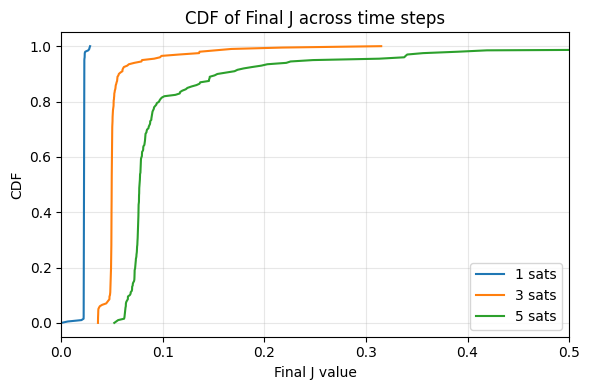

In [1]:
import json

data = []
with open("results_hist.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        data.append(json.loads(line))
import numpy as np
from collections import defaultdict

# 保存不同卫星数量下的 J 值
J_last_by_k = defaultdict(list)

for entry in data:
    hist = entry.get("hist", {})
    J_series = hist.get("J", [])
    if len(J_series) == 0:
        continue
    k = entry.get("k")
    J_last = np.real(J_series[-1])   # 取最后一个 J 值
    J_last_by_k[k].append(J_last)
    
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

for k_sel in sorted(J_last_by_k.keys()):
    vals = np.sort(np.array(J_last_by_k[k_sel]))
    cdf = np.linspace(0, 1, len(vals))
    plt.plot(vals, cdf, label=f"{k_sel} sats")

plt.xlabel("Final J value")
plt.ylabel("CDF")
plt.grid(True, alpha=0.3)
plt.legend()
plt.title("CDF of Final J across time steps")
plt.xlim(0, 0.5) 
plt.tight_layout()
plt.show()

In [6]:
import json
import matplotlib.pyplot as plt

def inspect_J_curve(filepath, method, step_idx):
    """
    检查结果文件中某个方法(method)和时间步(step_idx)对应的 J 曲线。
    
    Args:
        filepath : str, JSONL 文件路径 (如 "results_hist.jsonl")
        method   : str, 方法名 (例如 "MirrorProx" 或 "BestResp")
        step_idx : int, 要查看的 step 索引 (即你的 for 循环中的 step_idx)
    Returns:
        int : J 的长度
    """
    # 逐行读取文件
    with open(filepath, "r", encoding="utf-8") as f:
        entries = [json.loads(line) for line in f if line.strip()]
    
    # 过滤出对应的方法和step
    matches = [e for e in entries if e.get("method") == method and e.get("step_idx") == step_idx]
    
    if len(matches) == 0:
        print(f"⚠️ 没找到 method='{method}', step={step_idx} 的数据")
        return None
    
    # 通常每个 step 可能有多个 k（1,3,5）
    for e in matches:
        k = e.get("k")
        hist = e.get("hist", {})
        J = hist.get("J", [])
        if not J:
            print(f"⚠️ k={k} 没有 J 数据")
            continue
        
        print(f"✅ method={method}, step={step_idx}, k={k}, len(J)={len(J)}")
        plt.plot(J, label=f"{method} k={k} (len={len(J)})")

    plt.xlabel("Iteration")
    plt.ylabel("J value")
    plt.title(f"J evolution: method={method}, step={step_idx}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return


✅ method=BestResp, step=127, k=1, len(J)=1000
✅ method=BestResp, step=127, k=3, len(J)=1000
✅ method=BestResp, step=127, k=5, len(J)=1000


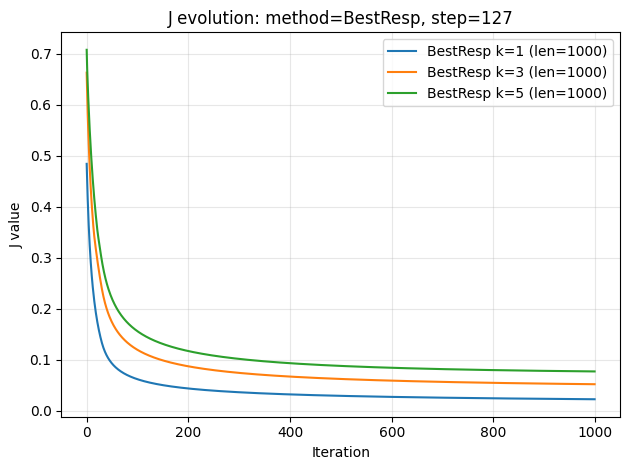

In [12]:
inspect_J_curve("results_hist.jsonl", method="BestResp", step_idx=127)